# Exploration of new energy-dependent USU functionality

In this notebook, we study the impact of the inclusion of energy-dependent USU uncertainties on the evaluation. The Bayesian update formula is the starting point,
$$ \rho(\vec{\sigma} \,|\, \vec{m}, \Sigma) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma) \times \rho(\vec{\sigma})$$
with $\vec{\sigma}$ the true cross sections that shall be determined, $\vec{m}$ the measured values and $\Sigma$ the experimental covariance matrix. The model $\mathcal{M}$ is responsible for mapping the cross sections given on the energy grid of $\vec{\sigma}$ to the energies of the measured values given in $\vec{m}$. If $\mathcal{M}$ is linear and the distributions on the right-hand side multivariate normal, also the posterior distribution (left-hand side) is multivariate normal whose center vector and covariance matrix can be obtained by the GLS equations.

For the consideration of energy-dependent USU, we introduce the following additional assumptions: Each dataset is associated with USU **errors** at a pre-defined energy mesh (e.g. 1, 2, 3, 4 MeV). These USU errors can not be measured and are unknown, therefore they are associated with an USU **uncertainty**. So for each energy $E_i$, each dataset $j$ has an USU **error** $\varepsilon_{ij}$. All USU errors at the same incident energy are associated with the same USU uncertainty $u_i$. We assume that the USU error at intermediate energies is given by linear interpolation of the USU errors at the enclosing energy points. Performing marginalization (integrating over the USU errors), yields a model where only the USU uncertainties remain, which are effectively parameters in the covariance matrix. The above statistical model therefore is modified in the following way:
$$ \rho(\vec{\sigma}, \Sigma(\vec{u}) \,|\, \vec{m}) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma(\vec{u})) \times \rho(\vec{\sigma}) \times \rho(\vec{u})$$
As can be seen, an additional prior distribution $\rho(\vec{u})$ is imposed on the USU uncertainties. We assume a uniform distribution from 0 to $+\infty$ for each element $u_i$ of the vector $\vec{u}$. The experimental covariance matrix is given by the covariance matrix from the GMA database file augmented with contributions from the energy-dependent USU uncertainties. With this augmented specification, there is no longer an analytic formula to calculate moments of the posterior distribution and we need to resort to Monte Carlo sampling. The Hamilton Monte Carlo algorithm can efficiently generate samples from the posterior distribution.

In the following, the results are presented for the simple toy scenario. The code to produce plots and results can be ignored. Text is provided in-between plots to explain the meaning of plots and results.

## Loading required packages and result files

Essential Python packages for visualiztion are loaded. In addition we prepare some quantities here, such as covariance matrices. The presentation of results start in the next section.

In [1]:
import sys
sys.path.append('../../..')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gmapy.data_management.object_utils import (
    load_objects, save_objects
)
import seaborn as sns
import tensorflow as tf

2023-09-01 15:20:24.896361: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 15:20:24.914347: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 15:20:25.029058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-01 15:20:25.029943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 15:20:25.642075: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
chain_relcov_usu, = load_objects('output/03_mcmc_sampling_output.pkl', 'chain')
priortable, exptable, usu_df, expcov, compmap, num_covpars = load_objects('output/01_model_preparation_output.pkl',
    'priortable', 'exptable', 'usu_df', 'expcov', 'compmap', 'num_covpars')
# load the experimental covariance matrices
like_cov_fun_rel_usu, = load_objects('output/01_model_preparation_output.pkl', 'like_cov_fun')
expcov_rel_nousu, = load_objects('../example-002/output/01_model_preparation_output.pkl', 'expcov_linop')
expcov_abs_nousu, = load_objects('../example-003/output/01_model_preparation_output.pkl', 'expcov_linop')
# for comparison, without usu and relative
chain_relcov_nousu, = load_objects('../example-002/output/03_mcmc_sampling_output.pkl', 'chain')
chain_abscov_nousu, = load_objects('../example-003/output/03_mcmc_sampling_output.pkl', 'chain')

In [3]:
# prepare absolute covmat
expvals = exptable.DATA.to_numpy()
absexpcov = expcov.toarray() * expvals.reshape((-1, 1)) * expvals.reshape((1, -1))
absexpuncs = np.sqrt(absexpcov.diagonal())
exptable['UNC'] = absexpuncs

As a reminder, here is the energy mesh used for both the theoretical cross sections and the experimental data:

In [4]:
priortable

,NODE,REAC,ENERGY,PRIOR,UNC,DESCR
0,xsid_1,MT:1-R1:1,1.00,1.198,inf,"U5(n,f)"
1,xsid_1,MT:1-R1:1,1.10,1.192,inf,"U5(n,f)"
2,xsid_1,MT:1-R1:1,1.25,1.210,inf,"U5(n,f)"
3,xsid_1,MT:1-R1:1,1.40,1.225,inf,"U5(n,f)"
4,xsid_1,MT:1-R1:1,1.60,1.254,inf,"U5(n,f)"
5,xsid_1,MT:1-R1:1,1.80,1.271,inf,"U5(n,f)"
6,xsid_1,MT:1-R1:1,2.00,1.286,inf,"U5(n,f)"
7,xsid_1,MT:1-R1:1,2.20,1.198,inf,"U5(n,f)"


## Original experimental data

First we plot the experimental data along with their uncertainties to obtain a visual impression of the degree of inconsistency. All points lie on the same discrete energy grid so we apply a bit of jitter on the energies to make the points and errorbars visually distinguishable.

Text(0, 0.5, 'cross section')

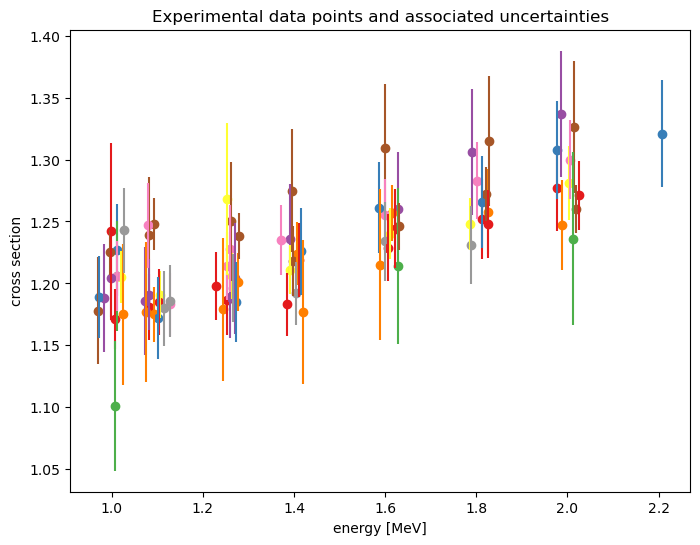

In [5]:
num_groups = len(exptable['NODE'].unique())
color_palette = sns.color_palette("Set1", n_colors=num_groups)
jittered_x = exptable['ENERGY'] + np.random.uniform(-0.03, 0.03, len(exptable))
exptable['jitx'] = jittered_x
plt.figure(figsize=(8,6))
for i, (group, group_data) in enumerate(exptable.groupby('NODE')):
    color = color_palette[i]
    plt.scatter(group_data['jitx'], group_data['DATA'], color=color)
    plt.errorbar(group_data['jitx'], group_data['DATA'], yerr=group_data['UNC'], color=color, linestyle='')
plt.title('Experimental data points and associated uncertainties')
plt.xlabel('energy [MeV]')
plt.ylabel('cross section')

## Determination of USU uncertainties

As mentioned above, USU uncertainties are given on a pre-defined energy mesh (1, 2, 3, 4 MeV). They characterize how much the USU errors are expected to scatter. The following plots show the posterior distribution of the USU uncertainty at the respective energy points. As all the experimental data are between 1 and 2 MeV, the posterior of the USU uncertainty at 1 and 2 MeV are peaked with the maximum of the distribution being at about 2\%. In contrast, no experimental data points are above 2 MeV, so there is no experimental information there to inform USU uncertainties. Therefore, the distributions for those cases are very uninformative, hence samples of the USU uncertainty span many orders of magnitude. Normally, it is a waste of computational power to include variables where we know that they are not informed by the likelihood. It is done here merely to demonstrate that the procedure yields the expected result. Please also note that the shape of histograms above 2 MeV should be ignored as it is impossible to converge an improper flat prior distribution from 0 to $+\infty$ without feedback from experimental data.

Text(0.5, 1.0, 'Posterior of USU uncertainty at 4.0 MeV')

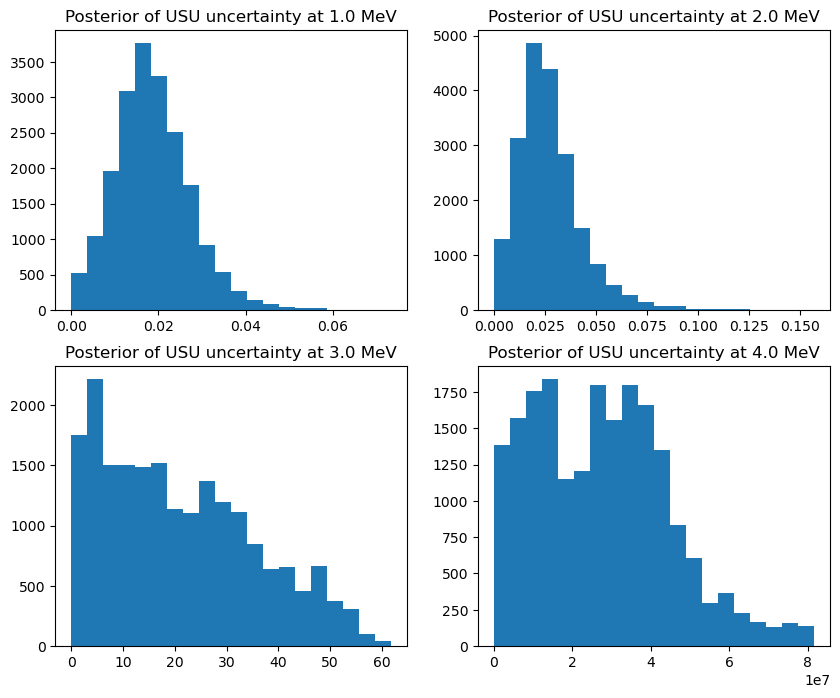

In [6]:
usu_energies = np.sort(pd.unique(usu_df.ENERGY))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes[0, 0].hist(np.abs(chain_relcov_usu[:,-num_covpars]), bins=20)
axes[0, 0].set_title(f'Posterior of USU uncertainty at {usu_energies[0]} MeV')
axes[0, 1].hist(np.abs(chain_relcov_usu[:,-num_covpars+1]), bins=20)
axes[0, 1].set_title(f'Posterior of USU uncertainty at {usu_energies[1]} MeV')
axes[1, 0].hist(np.abs(chain_relcov_usu[:,-num_covpars+2]), bins=20)
axes[1, 0].set_title(f'Posterior of USU uncertainty at {usu_energies[2]} MeV')
axes[1, 1].hist(np.abs(chain_relcov_usu[:,-num_covpars+3]), bins=20)
axes[1, 1].set_title(f'Posterior of USU uncertainty at {usu_energies[3]} MeV')

## Impact of USU uncertainties on the evaluation mean values

USU uncertainties are inferred at the same time as the true cross sections. In the following we compare how an evaluation with the consideration of USU uncertainties is different from one without. We have studied three cases:

- **blue**: we use a relative experimental covariance matirx (~PPP correction) and take into account USU
- **green**: we use a relative experimental covariance matrix (~PPP correction) without USU
- **red**: we use an absolute experimental covariance matrix without USU

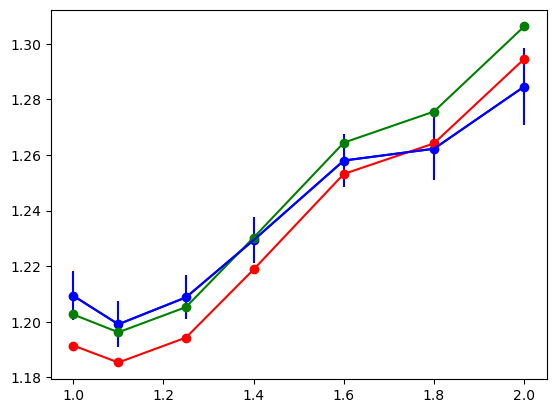

In [7]:
neg_idx = -(num_covpars+1)
energies = priortable['ENERGY'].to_numpy()[:-1]
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:neg_idx], axis=0)
postuncs_relcov_usu = np.std(chain_relcov_usu[:,:neg_idx], axis=0)
plt.plot(energies, postvals_relcov_usu, marker='o', color='blue')
plt.errorbar(energies, postvals_relcov_usu, postuncs_relcov_usu, color='blue')
# for comparison without USU but with relative experimental covmat
postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:-1], axis=0)
postuncs_relcov_nousu = np.std(chain_relcov_nousu[:,:-1], axis=0)
plt.plot(energies, postvals_relcov_nousu, marker='o', color='green')
# for comparison without USU and with absolute experimental covmat
postvals_abscov_nousu = np.mean(chain_abscov_nousu[:,:-1], axis=0)
postuncs_abscov_nousu = np.std(chain_abscov_nousu[:,:-1], axis=0)
plt.plot(energies, postvals_abscov_nousu, marker='o', color='red')

Focusing our attention on the cases based on the relative covariance matrix (blue, green),
we see that the consideration of USU (blue) significantly shifts the evaluation downwards at higher energies compared to the no USU case (green). Is this reasonable? To explore this difference further, we plot all experimental data in comparison to the evaluated values. 2 data points lie above and 7 below the green line. In contrast, it is 4 versus 6 for the blue line. We can conclude that in this particular case the evaluated value accounting for USU seems to be a more plausible result.

array([1.28462863])

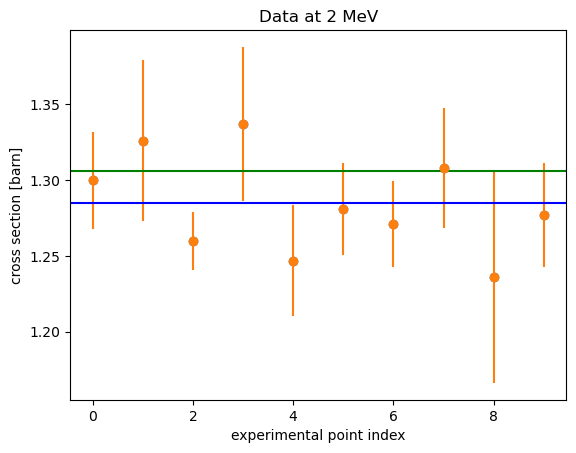

In [8]:
rdt = exptable.loc[exptable.ENERGY == 2.0]
plt.plot(np.arange(len(rdt.DATA)), rdt.DATA, linestyle='', marker='o')
plt.errorbar(np.arange(len(rdt.DATA)), rdt.DATA, rdt.UNC, linestyle='', marker='o')
plt.axhline(postvals_relcov_usu[energies == 2.0], color='blue')
plt.axhline(postvals_relcov_nousu[energies == 2.0], color='green')
plt.title('Data at 2 MeV')
plt.xlabel('experimental point index')
plt.ylabel('cross section [barn]')
postvals_relcov_usu[energies==2.0]

## Impact of USU consideration on evaluated uncertainties

Here we study how the consideration of USU changes the evaluated uncertainties. Same color code as before. The additional uncertainty due to the consideration of USU significantly expands the evaluated uncertainties.

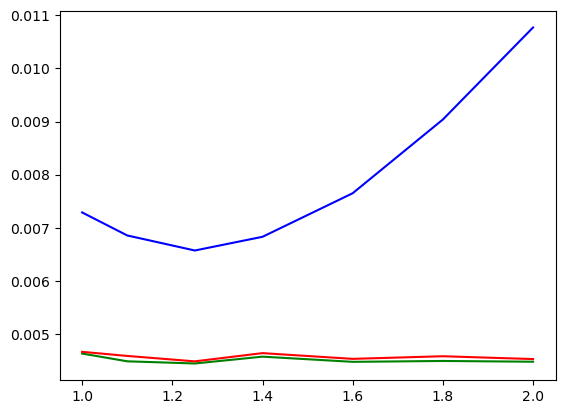

In [9]:
# comparison of posterior uncertainties
plt.plot(energies, postuncs_relcov_usu / postvals_relcov_usu, color='blue')
plt.plot(energies, postuncs_relcov_nousu / postvals_relcov_nousu, color='green')
plt.plot(energies, postuncs_abscov_nousu / postvals_abscov_nousu, color='red')

## Chisquare value comparison

For the proper calculation of the chisquare value, we need into account two factors: First, the evaluated cross section curve is associated with an evaluated covariance matrix. The larger the elements in the evaluated covariance matrix, the more we can tolerate larger deviations of experimental measurement points from the evaluation. Second, larger elements in the experimental covariance matrices also permit larger deviations between evaluated and measured values. Therefore, the correct covariance matrix for the computation of the $\chi^2$-value is given by:
$$\Sigma = \Sigma_{\textrm{exp}} + \Sigma_{\textrm{eval}}$$
In the case of USU uncertainties compiled in the vector $\vec{u}$, the experimental covariance matrix is a function, $\Sigma_{\textrm{exp}}(\vec{u})$. In this case, we could use the posterior expectation value of the experimental covariance matrix, i.e. $E\left[ \Sigma_\textrm{exp}(\vec{u}) \right] = \int \Sigma_\textrm{exp}(\vec{u}) \, du_1 du_2 \dots du_n$. However, to simplify matters for this quick comparison, we use the posterior expectation of the usu uncertainties $\vec{u}$ to construct the covariance matrix, i.e., $\Sigma_\textrm{exp}(E[\vec{u}])$.

In [10]:
# compute the evaluated covariance matrix 
eval_cov = np.cov(chain_relcov_usu[:,:-num_covpars].numpy().T)
# propagate this covariance matrix to the experimental measurements
ext_postvals_relcov_usu = np.mean(chain_relcov_usu[:, :-num_covpars], axis=0)
jac = tf.sparse.to_dense(compmap.jacobian(ext_postvals_relcov_usu)).numpy()
eval_cov2 = jac @ eval_cov @ jac.T
# compute the posterior expectation of the USU uncertainties
post_usu_pars = np.mean(np.abs(chain_relcov_usu[:, -num_covpars:]), axis=0)

In [11]:
def chisquare(postvals, covop_linop):
    totcov_linop = eval_cov2 + covop_linop.to_dense().numpy()
    propvals = compmap(postvals).numpy()
    d = np.reshape(propvals - exptable['DATA'].to_numpy(), (-1, 1))
    chisqr = d.T @ np.linalg.solve(totcov_linop, d) / len(exptable)
    return np.squeeze(chisqr)

def rel2abs_covop(postvals, covop_linop):
    propvals = compmap(postvals).numpy()
    scale_op = tf.linalg.LinearOperatorDiag(propvals)
    return tf.linalg.LinearOperatorComposition([scale_op, covop_linop, scale_op.adjoint()])

In [12]:
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:-num_covpars], axis=0)
postvals_abscov_nousu = np.mean(chain_abscov_nousu[:,:], axis=0)
postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:], axis=0)
postuncs_relcov_usu = np.std(chain_relcov_usu[:,:-num_covpars], axis=0)
postuncs_abscov_nousu = np.std(chain_abscov_nousu[:,:], axis=0)
postuncs_relcov_nousu = np.std(chain_relcov_nousu[:,:], axis=0)

tmp = rel2abs_covop(postvals_relcov_usu, like_cov_fun_rel_usu(post_usu_pars))
chisquare_relcov_usu = chisquare(postvals_relcov_usu, tmp)
tmp = rel2abs_covop(postvals_relcov_nousu, expcov_rel_nousu)
chisquare_relcov_nousu = chisquare(postvals_relcov_nousu, tmp)
chisquare_abscov_nousu = chisquare(postvals_abscov_nousu, expcov_abs_nousu)
print(f'chisquare with USU augmented experimental covmat: {chisquare_relcov_usu}')
print(f'chisquare with relative experimental covmat: {chisquare_relcov_nousu}')
print(f'chisquare with absolute experimental covmat: {chisquare_abscov_nousu}')

chisquare with USU augmented experimental covmat: 1.9344764144050584
chisquare with relative experimental covmat: 3.212749609471026
chisquare with absolute experimental covmat: 3.1855011103465793


## Evaluated values and uncertainties in table form

In [13]:
result_table = pd.DataFrame({
    'DESCR': priortable.DESCR,
    'ENERGY': priortable.ENERGY,
    'RES_RELCOV_USU': postvals_relcov_usu,
    'UNC_RELCOV_USU': postuncs_relcov_usu / postvals_relcov_usu,
    'RES_RELCOV_NOUSU': postvals_relcov_nousu,
    'UNC_RELCOV_NOUSU': postuncs_relcov_nousu / postvals_relcov_nousu,
    'RES_ABSCOV_NOUSU': postvals_abscov_nousu,
    'UNC_ABSCOV_NOUSU': postuncs_abscov_nousu / postvals_abscov_nousu
})
result_table

,DESCR,ENERGY,RES_RELCOV_USU,UNC_RELCOV_USU,RES_RELCOV_NOUSU,UNC_RELCOV_NOUSU,RES_ABSCOV_NOUSU,UNC_ABSCOV_NOUSU
0,"U5(n,f)",1.00,1.209341,0.007290,1.202606,0.004634,1.191434,0.004667
1,"U5(n,f)",1.10,1.199081,0.006857,1.196202,0.004488,1.185334,0.004589
2,"U5(n,f)",1.25,1.208777,0.006574,1.205267,0.004447,1.194293,0.004487
3,"U5(n,f)",1.40,1.229380,0.006832,1.230286,0.004576,1.218819,0.004642
4,"U5(n,f)",1.60,1.258006,0.007652,1.264454,0.004478,1.253180,0.004534
5,"U5(n,f)",1.80,1.262262,0.009040,1.275656,0.004495,1.264191,0.004584
6,"U5(n,f)",2.00,1.284629,0.010772,1.306262,0.004480,1.294572,0.004530
7,"U5(n,f)",2.20,5.784339,0.893190,1.302656,0.017053,1.293457,0.017928


## Evaluated correlation matrix

Text(0.5, 1.0, 'Evaluated correlation matrix')

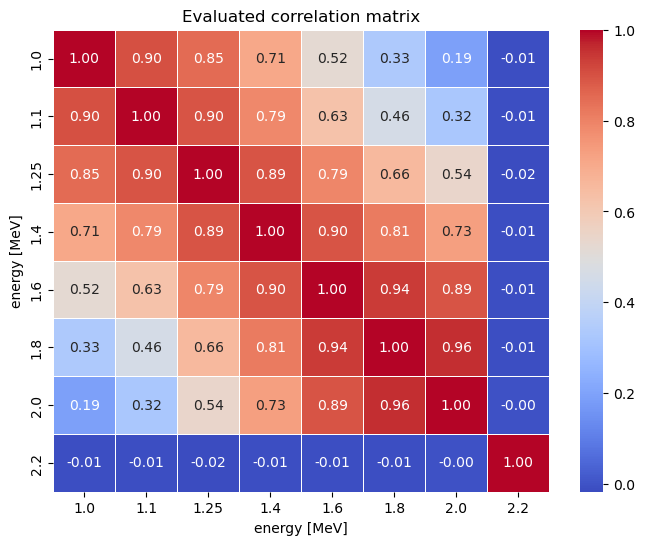

In [14]:
std_devs = np.sqrt(eval_cov.diagonal())
eval_cormat = eval_cov / np.outer(std_devs, std_devs)
custom_labels = priortable.ENERGY.to_numpy()
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(eval_cormat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
heatmap.set_xlabel('energy [MeV]')
heatmap.set_ylabel('energy [MeV]')
plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.title('Evaluated correlation matrix')